In [51]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

# 데이터 받기

In [52]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

# Normarlize

generator에서 tanh를 activation으로 활용할 것이다.  
tanh를 활용하면 output이 -1 ~ 1 사이로 나오기 때문에  
Normalize를 해줄 때 127.5로 나눈 뒤 1을 빼주어  
범위를 -1~1 사이로 만들어 준다.  

In [53]:
x_train.min(), x_train.max()

(0, 255)

In [54]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [55]:
x_train.min(), x_train.max()

(-1.0, 1.0)

###### x_train 값은 현재 28 * 28로 되어 있는 것을 Flatten하게 차원을 줄인다.

In [56]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

# Hyperparameters

GAN에 입력되는 Noise에 대한 차원을 설정해보자

In [57]:
NOISE_DIM = 10

# Generator 생성자 정의

In [59]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 256)               2816      
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_39 (Dense)            (None, 784)              

# Discriminator 판별자 정의

In [60]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_41 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 256)             

###### Compile
- binary_crossentropy 로스로 컴파일 해준다.

In [61]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# GAN 구성

이제 생성자와 판별자를 연결하자.
- GAN 모델에서는 생성자(Generator)만 학습하도록 하고, 판별자(Discrimnatore)는 학습을 하지 않도록 한다.

In [62]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,)) ##10차원
x = generator(inputs=gan_input)
output = discriminator(x)

In [63]:
gan = Model(gan_input, output)

In [64]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 sequential_9 (Sequential)   (None, 784)               1463312   
                                                                 
 sequential_10 (Sequential)  (None, 1)                 1460225   
                                                                 
Total params: 2923537 (11.15 MB)
Trainable params: 1463312 (5.58 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________


###### Compile
- GAN을 binary_crossentropy 로스로 컴파일 해준다.

In [65]:
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

### Batch 사이즈 설정
- MNIST 이미지 batch가 차례대로 생성되도록 이지미 batch를 생성한다.

In [66]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size : (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

예를 들어 784개 피쳐를 가진 6만개 데이터
```
x_train.shape
```
```
>>> (60000, 784)
```
get_batches를 이용하여 784개의 피쳐를 가진 6천개 *10 데이토로 바꿔준다.

```
get_batches(x_train, 10).shape
```
```
>>> (6000, 10, 784)
```

# 시각화 함수 정의

In [67]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 모델 학습하기

- 배치사이즈 256
- epochs = 50

In [68]:
BATCH_SIZE = 256
EPOCHS= 50

In [69]:
d_losses = [] # 판별자 loss
g_losses = [] # GAN 모델의 loss

8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step


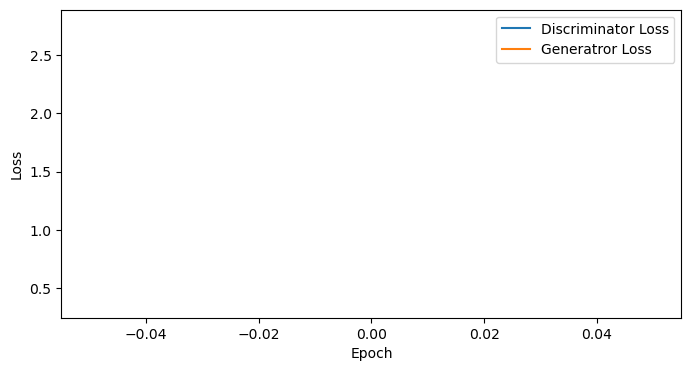

epoch: 1, Discriminator Loss: 0.36517274379730225, Generator Loss: 2.768360137939453
1/1 [==============================] - 0s 67ms/step


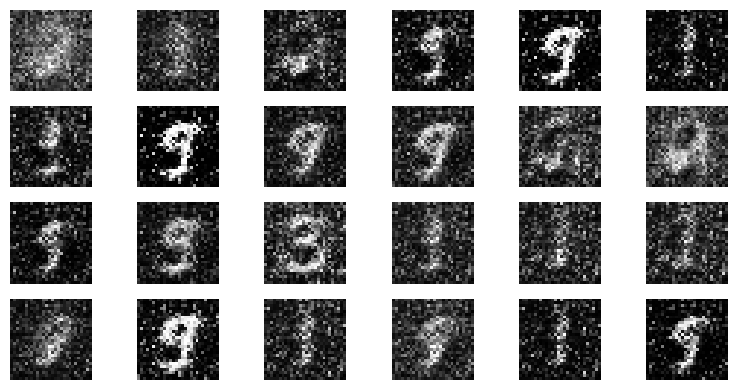

8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step


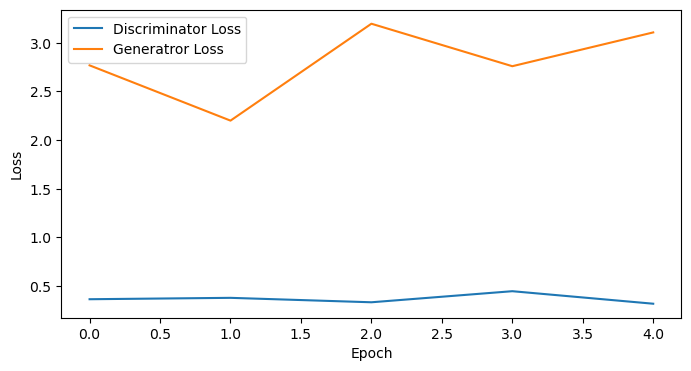

epoch: 5, Discriminator Loss: 0.3690268933773041, Generator Loss: 2.806237077713013
1/1 [==============================] - 0s 29ms/step


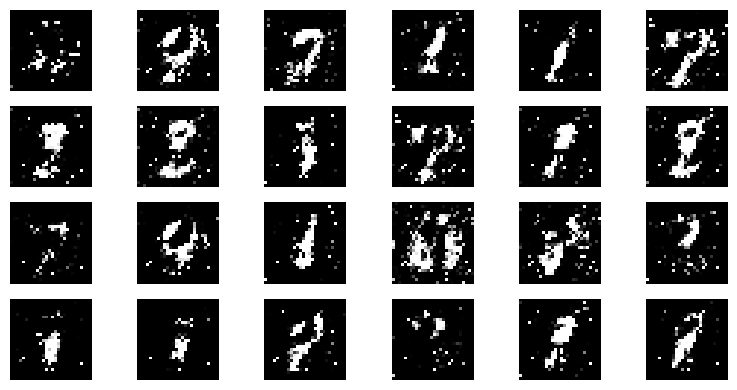

8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step


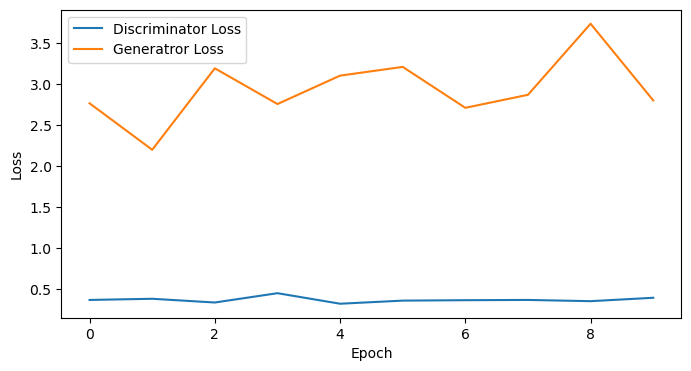

epoch: 10, Discriminator Loss: 0.3671358972787857, Generator Loss: 2.9375739812850954
1/1 [==============================] - 0s 28ms/step


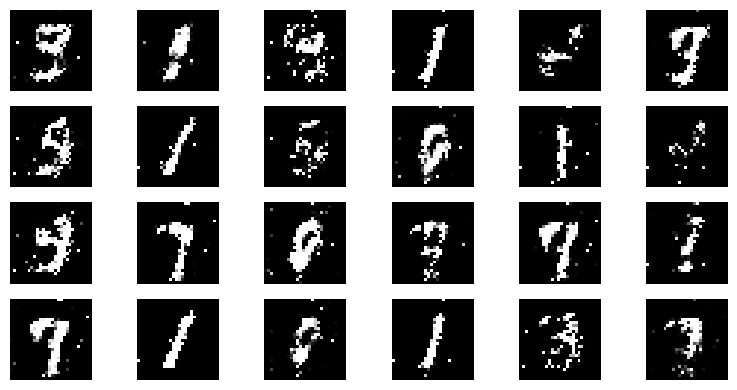

8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 5ms/step


KeyboardInterrupt: 

In [70]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)